In [1]:
import numpy as np
from neural_network_dynamics import main as ntwk
from datavyz import nrnvyz
from datavyz import gedn as ge
from model import Model


# Morphology analysis

In [44]:
from neural_network_dynamics import main as ntwk
from datavyz import nrnvyz
from datavyz import gedn as ge

In [2]:

from model import Model
import numpy as np
np.savez('study.npz', **Model)



Spreading 640 synapses over the segments
Spreading 640 synapses over the segments
Spreading 449 synapses over the segments
Spreading 457 synapses over the segments


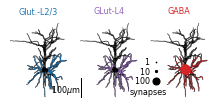

In [32]:
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])

## Spreading synapses


marker_size_factor = 0.5
# excitatory 
basal_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                            comp_type='dend',
                                            min_distance_to_soma=20e-6)
prox_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                                 comp_type=['dend', 'soma'],
                                                 max_distance_to_soma=20e-6)

Nsyn_GlutL23, pre_to_iseg_GlutL23, Nsyn_per_seg_GlutL23 = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGlut_L23'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GlutL4, pre_to_iseg_GlutL4, Nsyn_per_seg_GlutL4 = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGlut_L4'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GABAprox, pre_to_iseg_GABAprox, Nsyn_per_seg_GABAprox = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGABA_soma'],
                                                                          cond=prox_cond,
                                                                          density_factor=1./100./1e-12)

Nsyn_GABAdist, pre_to_iseg_GABAdist, Nsyn_per_seg_GABAdist = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                                          Model['DensityGABA_dend'],
                                                                          cond=basal_cond,
                                                                          density_factor=1./100./1e-12)
Nsyn_GABA = Nsyn_GABAdist+Nsyn_GABAprox
Nsyn_per_seg_GABA = Nsyn_per_seg_GABAdist+Nsyn_per_seg_GABAprox
pre_to_iseg_GABA = np.concatenate([pre_to_iseg_GABAprox,
                                   len(pre_to_iseg_GABAprox)+pre_to_iseg_GABAdist])


from datavyz import ge
fig, AX = ge.figure(axes_extents=[[[1,2],[1,2],[1,2]]], wspace=0.2, top=0.1, left=0)

vis = nrnvyz(SEGMENTS, ge=ge)

vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[0],
                  bar_scale_args={})
vis.add_dots(AX[0], np.arange(nseg)[Nsyn_per_seg_GlutL23>0],
             marker_size_factor*Nsyn_per_seg_GlutL23[Nsyn_per_seg_GlutL23>0], ge.blue)
ge.title(AX[0], 'Glut.-L2/3', color=ge.blue)

vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[1])
vis.add_dots(AX[1], np.arange(nseg)[Nsyn_per_seg_GlutL4>0],
             marker_size_factor*Nsyn_per_seg_GlutL4[Nsyn_per_seg_GlutL4>0], ge.purple)
ge.title(AX[1], 'GLut-L4', color=ge.purple)


vis.plot_segments(SEGMENTS['comp_type']!='axon', ax=AX[2], bar_scale_args={})
vis.add_dots(AX[2], np.arange(nseg)[Nsyn_per_seg_GABA>0],
             marker_size_factor*Nsyn_per_seg_GABA[Nsyn_per_seg_GABA>0], ge.red)
ge.title(AX[2], 'GABA', color=ge.red)
for i, x in enumerate([1, 10, 100]):
    xx, yy = -160, 40-i*50
    AX[2].scatter([xx], [yy], s=marker_size_factor*x, color='k')
    ge.annotate(AX[2], str(x)+' ', (xx-20, yy), xycoords='data', ha='right', va='center')
ge.annotate(AX[2], 'synapses', (0, 0.05), ha='center')


In [37]:
def set_background_network_stim(t, neuron, SEGMENTS, Model):
    
    L23spike_IDs, L23spike_times = ntwk.spikes_from_time_varying_rate(t, 0*t+Model['Fexc_bg'], N=Nsyn_GlutL23)
    L23stim, L23S = ntwk.process_and_connect_event_stimulation(neuron,
                                                               L23spike_IDs, L23spike_times,
                                                               pre_to_iseg_GlutL23,
                                                               EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                               ON_EXC_EVENT.format(**Model))
    L23S.X, L23S.bZn = 0, 0
    
    Model['Deltax0'] = 0.
    L4spike_IDs, L4spike_times = ntwk.spikes_from_time_varying_rate(t, 0*t+Model['Fexc_bg'], N=Nsyn_GlutL4)
    L4stim, L4S = ntwk.process_and_connect_event_stimulation(neuron,
                                                               L4spike_IDs, L4spike_times,
                                                               pre_to_iseg_GlutL4,
                                                               EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                               ON_EXC_EVENT.format(**Model))
    L4S.X, L4S.bZn = 0, 0
    
    GABAspike_IDs, GABAspike_times = ntwk.spikes_from_time_varying_rate(t, 0*t+Model['Finh_bg'], N=Nsyn_GABA)
    Istim, IS = ntwk.process_and_connect_event_stimulation(neuron,
                                                           GABAspike_IDs, GABAspike_times,
                                                           pre_to_iseg_GABA,
                                                           INH_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_INH_EVENT.format(**Model))
    

    # return Estim, ES, Istim, IS
set_background_network_stim(t, neuron, SEGMENTS, Model)

In [ ]:
def run(neuron, Model, Estim, ES, Istim, IS):
    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0, Model['stim_apic_compartment_index']])
    S = ntwk.StateMonitor(ES, ('X', 'bZn'), record=[0])
    
    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms),
              'Vm_soma':np.array(M.v/ntwk.mV)[0,:],
              'bZn_syn':np.array(S.bZn)[0,:],
              'X_syn':np.array(S.X)[0,:],
              'Vm_syn':np.array(M.v/ntwk.mV)[1,:]}

    output['Ic'] = (output['Vm_soma']-Model['VC-cmd'])*Model['VC-gclamp'] # nA
    return output


In [34]:
from single_cell_sim import *

t, neuron, SEGMENTS = initialize_sim(Model)
set_background_network_stim(t, neuron, SEGMENTS, Model)

In [ ]:
prox_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
m 

                                                comp_type=['dend', 'soma'])
np.sum(prox_cond)

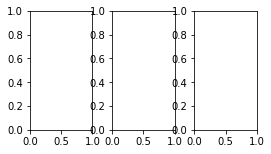

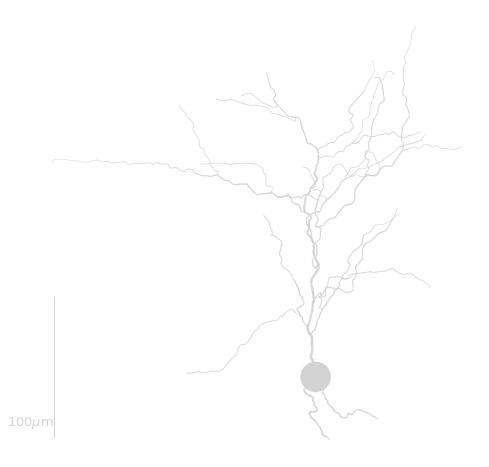

In [16]:
fig, ax = vis.plot_segments(cond=((SEGMENTS['comp_type']=='soma') | (SEGMENTS['comp_type']=='apic')))


In [10]:
np.unique(SEGMENTS['comp_type'])

array(['apic', 'axon', 'dend', 'soma'], dtype='<U4')

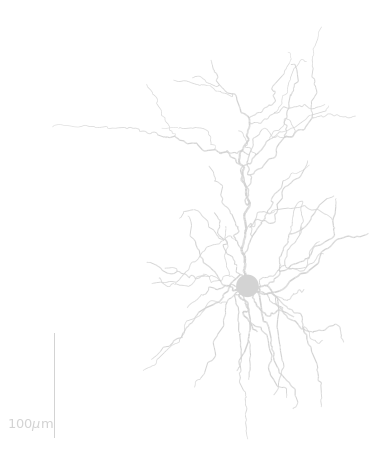

In [9]:
fig, ax = vis.plot_segments(cond=[True if c in ['dend', 'soma', 'apic'] else False\
                                  for c in SEGMENTS['comp_type']])


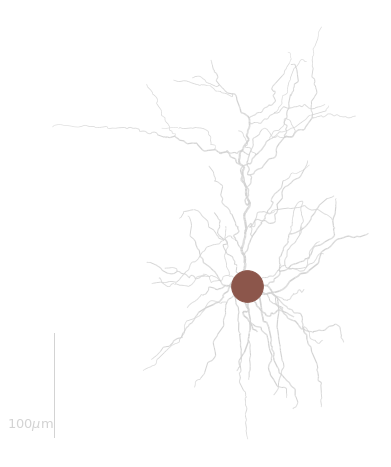

In [13]:


# pre_subset = np.random.choice(pre_to_iseg_Exc, int(Nsyn_Exc/10))

# vis.add_dots(ax, isegs, 5*sizes, 'r')
#vis.add_dots(ax, pre_subset, 10*np.ones(len(pre_subset)), 'r')
#vis.add_circle(ax, [0], [100 ], ge.brown, lw=5)
ax.scatter([0], [0], s=200, c=ge.brown, zorder=100)


Spreading 2442 synapses over the segments


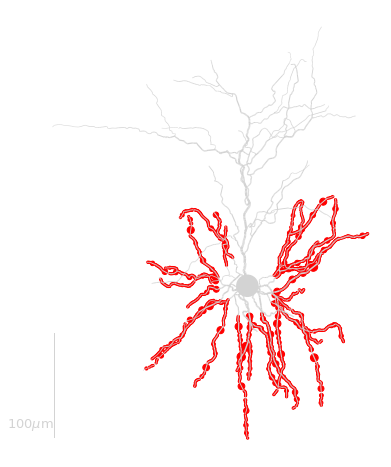

In [9]:
from datavyz import gedn as ge
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])
from datavyz.nrn_morpho import nrnvyz
vis = nrnvyz(SEGMENTS,
             ge=ge)
fig, ax = vis.plot_segments(cond=[True if c in ['dend', 'soma', 'apic'] else False\
                                  for c in SEGMENTS['comp_type']])

def distance(x, y, z):
    return np.sqrt(x**2+y**2+z**2)

cond = (distance(SEGMENTS['x'], SEGMENTS['y'], SEGMENTS['z'])>30e-6) & (SEGMENTS['comp_type']=='dend')
_, N_syn = spread_synapses_on_morpho(SEGMENTS, Model['DensityAMPA'],
                                    cond=cond,
                                    density_factor=1./100./1e-12,
                                    verbose=True)
isegs = np.arange(nseg)[N_syn>0]
sizes = N_syn[N_syn>0]
vis.add_dots(ax, isegs, 5*sizes, 'r')
# for i, n in enumerate(N_syn):
#     vis.add_dot(ax, i, 5*n, 'r')


In [16]:
"""
{params}
""".format(**{'params':3})

'\n3\n'

In [7]:
morpho1 = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
morpho2 = ntwk.Morphology.from_swc_file(Model['morpho_file_2'])
# fetching all compartments
# COMP_LIST, SEG_INDICES = ntwk.morpho_analysis.get_compartment_list(morpho)
#SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)

In [6]:
from datavyz import gedn as ge


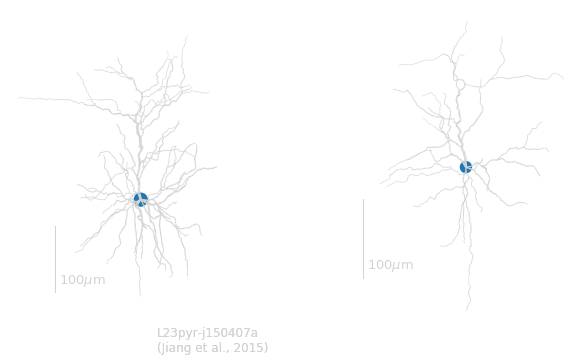

In [23]:
from datavyz import gedn as ge
from datavyz.nrn_morpho import plot_nrn_shape

fig, AX = ge.figure(axes=(2,1),
                    figsize=(1.2,3.), left=0, right=0., top=0., bottom=0.08)

for morpho, ax in zip([morpho1, morpho2], AX):
    SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
    plot_nrn_shape(ge, SEGMENTS,
                   comp_type=['dend', 'soma', 'apic'],
                   ax=ax,
                   bar_scale_args=dict(loc=(-130,-140), Ybar=100, Ybar_label=' 100$\mu$m', 
                                   orientation='left-top'))
    ge.annotate(fig, 'L23pyr-j150407a\n(Jiang et al., 2015)', (0.27,0.02), size='small')
#ge.save_on_desktop(fig2)

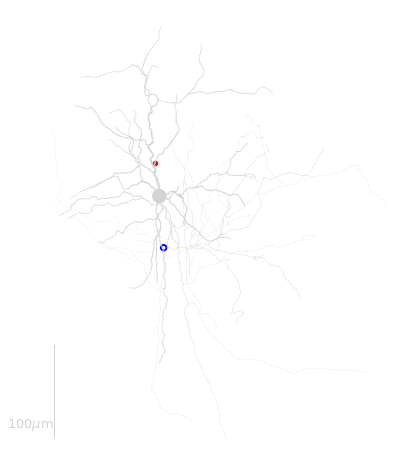

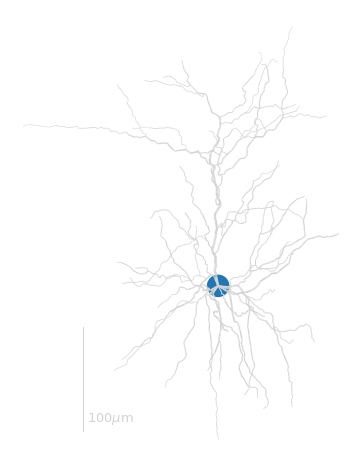

In [20]:
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho1)
plot_nrn_shape(ge, SEGMENTS,
               comp_type=['dend', 'soma', 'apic'],
               bar_scale_args=dict(loc=(-130,-140), Ybar=100, Ybar_label=' 100$\mu$m', 
                                   orientation='left-top'),
               polar_angle=0, azimuth_angle=6);


In [21]:
SEGMENTS['diameter']

Quantity(array([2.166e-05, 1.840e-06, 1.840e-06, ..., 1.250e-06, 1.250e-06,
       1.250e-06]))

In [22]:
print(1e12*np.sum(SEGMENTS['area']))

28518.324899022893


# Synaptic model of NMDAR signaling

The time evolution of the NMDA conductance is taken as the combination of four terms: 1) a synaptic waveform, 2) a conductance quantal setting the maximum conductance at full-activation level , 3) a voltage-dependent term (Mg block), 4) a Zn$^{2+}$-inhibition term set as $\big(1 - \alpha_{Zn} \, b_{Zn} \big)$ where $\alpha_{Zn}$ is the fraction of inhibited conductance at maximum Zinc-binding level ($b_{Zn}$=1). This is captured by the equation:

\begin{equation}
g_{NMDA}(V_m, b_{Zn}, t) = N_{Mg}(V_m) \cdot \big(1 - \alpha_{Zn} \, b_{Zn} \big) \cdot Q_{NMDA} \cdot F_{NMDA}(t)
\end{equation}

Following previous modeling work (Ascher and Nowak, 1988; ... ; Farinella et al, 2015; ...; ), the voltage 

Following previous modeling work (Farinella et al, 2015; ...; Ascher and Nowak, 1988), the 


where $F_{NMDA}(t)$ is the temporal waveform of the synaptic event.

, taken as the double exponential waveform: $F_{NMDA} : t \rightarrow A_{NMDA} \cdot (e^{-t/\tau^{decay}_{NMDA}} - e^{-t/\tau^{rise}_{NMDA}} ) $ normalized to its peak-level with the factor $A_{NMDA} = \frac{1}{(\tau^{decay}_{NMDA}/\tau^{rise}_{NMDA}-1} \cdot (\tau^{decay}_{NMDA}/\tau^{rise}_{NMDA})^{\frac{\tau^{decay}_{NMDA}}{\tau^{decay}_{NMDA}-\tau^{rise}_{NMDA}}} $.

\begin{equation}
g^{max}_{NMDA}(V_m, b_{Zn}, t) = Q_{NMDA} \cdot N_{Mg}(V_m) \cdot \big(1 - \alpha_{Zn} \, b_{Zn} \big)
\end{equation}

## Modeling Zinc modulation of NMDAR signaling

We next introduce a biophysical model for the modulation of synaptic transmission due to Zinc binding (illustrated on **Figure Xa**). 


The maximum conductance following a synaptic event is set by the following product: **a)** A conductance quantal setting the maximum conductance at full-activation level , **b)** a voltage-dependent term (Mg block), **c)** a Zn$^{2+}$-inhibition term set as $\big(1 - \alpha_{Zn} \, b_{Zn} \big)$ where $\alpha_{Zn}$ is the fraction of inhibited conductance at maximum binding level ($b_{Zn}$=1).



The bounded-Zinc variable fully describes the phenomenon, without any other underlying dynamics, the temporal dynamics applies to that specific variable. At each synaptic event, Zinc is released and increments the effective-binding variable (bZn), each increment is followed by a decay to model the unbinding dynamics. Here, the on-linearity is model by a state-dependent (bZn-dependent) increment of the bounded-Zn variable (bZn), the higher bZn, the lower the increment (to produce the saturation up to 1).
    
The system of equation for such a model reads:
    
\begin{equation}
\left\{
\begin{split}
\tau^{decay}_{Zn} \cdot \frac{d x}{ dt }  = & - x + \Delta_x ( x )  \sum_{\{t^{k}\}_{glut}} \delta (t-t^k) \\
\tau^{rise}_{Zn} \cdot \frac{d b_{Zn}}{ dt }  = & - b_{Zn} + \mathcal{S}(\frac{x-x_0}{\delta x}) 
\end{split}
\right.
\end{equation}

where $\Delta_x (x)$ is the ($x$-dependent) increment defined by  $\Delta_x : x \rightarrow \Delta_x^0 \cdot \big(1- x \big)$, .

Binding dynamics is implemented by low-pass filtering 

The function $\mathcal{S}$ is the sigmoid function defined by: $\mathcal{S} : X \rightarrow \frac{1}{1+e^{-X}}$, the parameters $x_0$ and $\delta x$ therefore define the center and slope of the sigmoid.

In [1]:
%matplotlib inline
from datavyz import ge
import numpy as np

In [ ]:
# Mechanism detail

In [38]:
# all parameters in SI units ! (i.e. volts, amps, siemens, seconds, ...)

params = {
    # NMDA
    'Trise_NMDA':7e-3,
    'Tdecay_NMDA':70e-3,
    'Q_NMDA':1e-9, # i.e. from 'NMDA-to-AMPA-ratio':0.8,
    'Erev_NMDA':0e-3,
    # Vm-modul NMDA
    'V0_NMDA':1./0.08,
    # Zn-modul NMDA 
    'dx_Zn':0.3,
    'sx_Zn':0.1,
    'Tdecay_Zn':0.3,
    'Trise_Zn':20e-3,
    'alpha_Zn':0.4, # fraction of inactivated conductance at peak 
}

In [42]:
import numpy as np
from scipy.special import erf

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS, t,
                                        Trise=.1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance


def compute_pre_from_events(SET_OF_EVENTS, t, delay=0):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event-delay)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance

def sigmoid(x, x0=0.5, dx=0.1):
    return 1./(np.exp(-(x-x0)/dx)+1)

def sigmoid_deriv(x, dx=0.1):
    return np.exp(-(x-.5)/dx)/dx/(np.exp(-(x-.5)/dx)+1)**2

def voltage_dep_NMDA(x):
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=0.4):
    return b0*(1-b)

def solve_synapse_equation(t, params,
                           Glut_events=[],
                           alpha_Zn=0.4,
                           Vm=None):
         
    dt = t[1]-t[0]
    pre_events = compute_pre_from_events(Glut_events, t)
    sim = {'t':t, 
           'Glut_event_trace':pre_events}

    # Ib
    xZn, bZn = 0*t, 0*t
    for i in range(len(t)-1):
        xZn[i+1] = xZn[i]-dt/params['Tdecay_Zn']*xZn[i]
        bZn[i+1] = bZn[i]+dt/params['Trise_Zn']*(sigmoid(xZn[i], x0=0.5, dx=params['sx_Zn'])-bZn[i])
        
        if pre_events[i+1]>0:
            xZn[i+1] += binding_increment(xZn[i+1], b0=params['dx_Zn'])
            #xZn[i+1] += sigmoid_deriv(xZn[i+1], dx=params['sx_Zn'])*params['dx_Zn']/sigmoid_deriv(0.5, dx=0.1)
           
    sim['bZn'], sim['xZn'] = bZn, xZn
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                    Trise=params['Trise_NMDA'], Tdecay=params['Tdecay_NMDA'], quantal=params['Q_NMDA'])    

    # modulation function:    
    def NMDA_modulation(Vm, bZn):
        return voltage_dep_NMDA(Vm)*(1.-params['alpha_Zn']*bZn)
    
    sim['gNMDA'] = NMDA_modulation(Vm,sim['bZn'])*gNMDA

    return sim

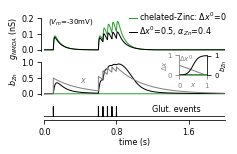

In [43]:
from datavyz import ge#n as ge
t = np.arange(2000)*1e-3
# same events in voltage-clamp -> hyperpolarized

EVENTS = [0.1]+list(np.arange(5)*0.05+.6)
#EVENTS = [0.1]+list(np.arange(20)*0.02+.7)


params['dx_Zn'] = 0
sim0 = solve_synapse_equation(t, params, Glut_events=EVENTS, Vm=-30e-3)
params['dx_Zn'] = 0.5
params['sx_Zn'] = 0.1
sim1 = solve_synapse_equation(t, params, Glut_events=EVENTS, Vm=-30e-3)


fig, AX = ge.figure(axes_extents=[[[1,2]],
                                  [[1,2]],
                                  [[1,1]]],
                    figsize=(1.7,.25), hspace=1.5, top=3., bottom=3., left=0.5, right=2.)

# model1
ge.plot(t, sim1['Glut_event_trace'], ax=AX[2],
        axes_args={'spines':['bottom'], 'xlabel':'time (s)', 'xlim':[t[0],t[-1]]})
ge.annotate(AX[2], 'Glut. events', (.6, .3))
AX[1].plot(t, 0*t,  lw=1, color=ge.green)
AX[1].plot(t, sim1['bZn'],  lw=1, color='k')
AX[1].plot(t, sim1['xZn'],  lw=1, color='gray')

ge.set_plot(AX[1], ['left'], ylabel='$b_{Zn}$', ylim=[-0.05,1.01], yticks=[0,0.5,1.], xlim=[t[0],t[-1]])

AX[0].plot(t, 1e9*sim0['gNMDA'],  color=ge.green, lw=1, label='chelated-Zinc: $\Delta x^0$=0')
AX[0].plot(t, 1e9*sim1['gNMDA'], color='k', lw=1,
           label='$\Delta x^0$=%.1f, $\\alpha_{Zn}$=%.1f' % (params['dx_Zn'], params['alpha_Zn']))
           
ge.set_plot(AX[0], ['left'], ylabel = '$g_{NMDA}$ (nS)    ',
            yticks = [0,.1,.2], xlim=[t[0],t[-1]])

ge.legend(AX[0], loc=(.45,.3), labelspacing=0.2)
ge.annotate(AX[0], '($V_m$=-30mV)', (.02,.75), size='small')


ge.annotate(AX[1], '$x$', (0.2, 0.3), color='gray')

ax = ge.inset(AX[1], [.75,.6,.15,.6])
x = np.linspace(0,1)

ax2 = ax.twinx()
ax2.plot(x, sigmoid(x, dx=params['sx_Zn']), 'k-', lw=1)
ge.set_plot(ax2, ['right'], size='small', yticks=[0,1],
            ylabel='$b_{Zn}$', xlim=[0,1], ylim=[0,1.01],
            tck_outward=0, ylabelpad=0)

ax.plot(x, params['dx_Zn']*(1-x), 'k-', lw=1, color='gray')
ax.plot(x, 0*x, color=ge.green, lw=2)
ge.annotate(ax, '$\Delta x^0$', (0., params['dx_Zn']), size='small', xycoords='data', color='gray')
ge.set_plot(ax, size='small', xticks=[0,1], yticks=[0,1],
            xlabel='$x$', ylabel='$\Delta x$', xlim=[0,1], ylim=[0,1],
            tck_outward=0, xlabelpad=-8, ylabelpad=-2, ycolor='grey', xcolor='grey')


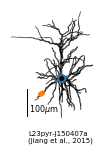

In [76]:
from datavyz import ge
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
nseg = len(SEGMENTS['x'])

vis = nrnvyz(SEGMENTS, ge=ge)

synapses_loc = 2450+np.arange(10)

fig2, ax = ge.figure(figsize=(1.2,3.), left=0, right=0., top=0., bottom=0.08)
vis.plot_segments(SEGMENTS['comp_type']!='axon',
                  ax=ax, bar_scale_args=dict(loc=(-130,-140), Ybar=100,
                                  Ybar_label=' 100$\mu$m', orientation='left-top'))
vis.add_dots(ax, synapses_loc, np.ones(len(synapses_loc))*20, ge.orange)
vis.add_circle(ax, 0, 50, ge.blue, lw=2)

ge.annotate(fig, 'L23pyr-j150407a\n(Jiang et al., 2015)', (0.27,0.02), size='small')
#ge.save_on_desktop(fig2)

In [3]:
from single_cell_sim import initialize_sim, EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

def run_demo_sim(Model,
                 Vcmd = -30,
                 t0_stim=100.,
                 freq_pulses=20., # Hz
                 n_pulses=5,
                 tstop=600.,
                 synapses_loc = 2450+np.arange(10)):

    Model['VC-cmd'] = Vcmd
    Model['tstop'] = tstop
    
    # initialize voltage-clamp sim
    t, neuron, SEGMENTS = initialize_sim(Model, method='voltage-clamp')

    spike_IDs, spike_times = np.empty(0, dtype=int), np.empty(0, dtype=float)
    for i in range(n_pulses):
        spike_times = np.concatenate([spike_times,
                                      (t0_stim+i*1e3/freq_pulses)*np.ones(len(synapses_loc))])
        spike_IDs = np.concatenate([spike_IDs,np.arange(len(synapses_loc))])
    
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           spike_IDs, spike_times,
                                                           synapses_loc,
                                                           EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_EXC_EVENT.format(**Model))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v', 'gE'), record=[0, synapses_loc[0]])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms),
              'Vm_soma':np.array(M.v/ntwk.mV)[0,:],
              'gAMPA_syn':np.array(S.gAMPA/ntwk.nS)[0,:],
              'gNMDA_syn':np.array(M.gE/ntwk.nS)[1,:]-np.array(S.gAMPA/ntwk.nS)[0,:],
              # 'gNMDA_syn':np.array(S.gNMDA/ntwk.nS)[0,:],
              'bZn_syn':np.array(S.bZn)[0,:],
              'X_syn':np.array(S.X)[0,:],
              'Vm_syn':np.array(M.v/ntwk.mV)[1,:]}

    output['Ic'] = (output['Vm_soma']-Model['VC-cmd'])*Model['VC-gclamp'] # nA
    return output

output = run_demo_sim(Model)

INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


(<Figure size 294.803x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f09221dd590>)

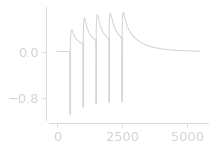

In [6]:
(output['gNMDA_syn']

ValueError: x and y must have same first dimension, but have shapes (5499,) and (2, 5499)

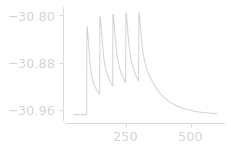

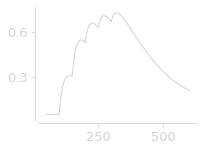

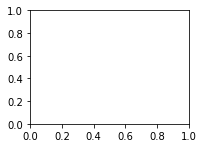

ValueError: x and y must have same first dimension, but have shapes (5499,) and (2, 5499)

In [5]:
cond = output['t']>50
ge.plot(output['t'][cond], output['Vm_soma'][cond])
ge.plot(output['t'][cond], output['bZn_syn'][cond])
ge.plot(output['t'][cond], [output['gAMPA_syn'][cond], output['gNMDA_syn'][cond]], ls=':')
ge.plot(output['t'][cond], 1e3*(output['Ic'][cond]-output['Ic'][cond][0]))


In [11]:
ge.multipanel_figure([fig, fig2],
                     LABELS=[['a','b']], Y_LABELS = [[0,0]],
                     X=[[0,230]],
                     Y=[[0,-8],
                        [150,150]],
                     width='one-and-a-half-column',
                     height=60.,
                     export_to_png=True,
                     fig_name='figures/fig-model-description.svg')

RUNNING: inkscape figures/fig-model-description.svg --export-area-page --export-background="white" --export-png="figures/fig-model-description.png" --export-dpi=300
[ok] figure successfully exported as: figures/fig-model-description.png


# Modeling Zinc modulation of NMDAR signaling

Model ingredients:

- Zinc inhibits NMDAR via a high-affinity binding mechanism
- NMDAR has its classical voltage dependency 
- Zinc inhibition is concentration dependent (with a half activation value in the nanomolar range) and voltage-independent
- Zinc is stored in synaptic vesicles and co-released with glutamate
- Zinc concentration in the synaptic cleft follows a release/re-uptake dynamics
- Zinc effect on NMDAR has a binding/unbinding dynamics

## Modeling Zinc modulation in a single compartment

In a single compartment model containing AMPA, NMDA and GABA synaptic currents, the membrane equation reads:

\begin{equation}
\label{eq:membrane-eq-single-comp}
\begin{split}
C_m \frac{dV_m}{dt} = & g_L \, \big(E_L - V_m \big) \\
                      + & g_{NMDA}(V_m, b_{Zn}, t) \, (E_{NMDA}-V_m) \\
                      + & g_{AMPA}(t)  \, (E_{AMPA}-V_m) \\
                      + & g_{GABA}(t)  \, (E_{GABA}-V_m)
\end{split}
\end{equation}

The AMPA and GABA synaptic currents depend on the conductances ($g_{AMPA}$ and $g_{GABA}$ respectively), they are voltage independent, their temporal dynamics are only constrained by the integration of synaptic events, i.e. they and follow the equations:

\begin{equation}
g_{AMPA}(t) =  Q_{AMPA} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{AMPA}^{rise}, \tau_{AMPA}^{decay})
\end{equation}

\begin{equation}
g_{GABA}(t) =  Q_{GABA} \, \sum_{\{t^{k}\}_{GABA}} \mathcal{H}(t-t^k) \cdot  B(t-t^k, \tau_{GABA}^{rise}, \tau_{GABA}^{decay})
\end{equation}

where:
\begin{equation}
B (t, \tau_1, \tau_2) = \frac{(\tau_2/\tau_1)^{\frac{\tau_2}{\tau_2-\tau_1}}}{\tau_2/\tau_1 -1 } \Big( e^{-t/\tau_2} - e^{-t/\tau_1} \Big)
\end{equation}
is the normalized double exponential function (peaking to 1 at maximum), where $Q_{AMPA}$ and $Q_{GABA}$ are the quantals of conductance increments at their respective events, and where $\{t^{k}\}_{glut}$ and $\{t^{k}\}_{GABA}$ are respectively the sets of glutamatergic and GABAergic presynaptic events.

In addition to its dependency on the set of glutamatergic synaptic events, the NMDA conductance has both a dependency on membrane depolarization ($V_m$) and on the Zinc-concentration ($c_{Zn}$), its equation is:

\begin{equation}
g_{NMDA}(V_m, c_{Zn}, t) = N(V_m) \cdot \big(1 - \alpha_{Zn} \, F(c_{Zn}) \big) \cdot Q_{NMDA} \, \sum_{\{t^{k}\}_{glut}}  \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{NMDA}^{rise}, \tau_{NMDA}^{decay})
\end{equation}

where $N(V_m)$ is the classical voltage-dependency of NMDA channels due to the Magnesium block described by (Farinella et al., 2014):

\begin{equation}
N(V_m) = \frac{1}{0.3+e^{- 80 * V_m} }
\end{equation}

where $\alpha_{Zn}$ is the fraction of inactivated NMDA channel at maximum inactivation (i.e. at high Zinc concentration), where $Q_{NMDA}$ is the quantal of (maximum) conductance increment and where $F(c_{Zn})$ is the relation between "effective" Zinc concentration and NMDA inactivation, this inactivation function is determined by the error function:

\begin{equation}
F(c_{Zn}) = (1+ Erf\big( \frac{c-c^0_{Zn}}{\delta c_{Zn}} \big))/2
\end{equation}

The temporal evolution of the "effective" Zinc concentration in the synaptic cleft is also determined by the set of glutametargic events with:
\begin{equation}
c_{Zn}(t) = Q_{Zn} \, \sum_{\{t^{k}\}_{glut}} \mathcal{H}(t-t^k) \cdot B(t-t^k, \tau_{Zn}^{rise}, \tau_{Zn}^{decay})
\end{equation}

----------------------------------------------

$Zn^{2+}$ chelation is modelled by $Q_{Zn}=0$ (the glutamate release does not lead to any increase of the "effective" Znc concentration), 

it could also be modelled by $\alpha_{Zn}$=0 (the variations of Zinc concentrations do not have any effect)

----------------------------------------------

TO BE DISCUSSED / SHAKY ASPECTS

- the Binding/Unbinding dynamics and the Release/Re-uptake dynamics are merged into a single "effective" Zinc dynamics for simplicity

- the Zinc concentration is a linear variable spanning [0,100nM], we could have it logarhitmically spanning [1nM, 1uM]


## Parameters

In [1]:
# all parameters in SI units ! (i.e. volts, amps, siemens, seconds, ...)

params = {
    # passive cellular properties
    'Cm':200e-12, # farad
    'gL':10e-9, # siemens
    'El':-70e-3, # volt
    # GABA
    'Trise_GABA':0.5e-3, # second
    'Tdecay_GABA':5e-3,
    'Q_GABA':1e-9,
    'Erev_GABA':-80e-3,
    # AMPA
    'Trise_AMPA':0.5e-3,
    'Tdecay_AMPA':5e-3,
    'Q_AMPA':1e-9,
    'Erev_AMPA':0e-3,
    # NMDA
    'NMDA-to-AMPA-ratio':0.8,
    'Trise_NMDA':7e-3,
    'Tdecay_NMDA':70e-3,
    'Q_NMDA':0.8e-9, # i.e. from 'NMDA-to-AMPA-ratio':0.8,
    'Erev_NMDA':0e-3,
    # Vm-modul NMDA
    'V0_NMDA':1./0.08,
    # Zn-modul NMDA
    'Q_Zn':5e-9, # increment of effective Zn concentration
    'C0_Zn':20e-9,
    'deltaC_Zn':10e-9,
    'Trise_Zn':15e-3,
    'Tdecay_Zn':0.3,
    'alpha_Zn':0.4, # fraction of inactivated conductance at peak 
}

params_no_Zn = params.copy() 
params_no_Zn['Q_Zn'] = 0

## Numerical implementation

In [1]:
import numpy as np
from scipy.special import erf

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS,
                                        t,
                                        Trise=1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance

def compute_pre_from_events(SET_OF_EVENTS, t):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance

def voltage_dep_NMDA(x):
    """
    x should be in volts !!
    
    taken from Farinella et al. (2014)
    """
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=0.4):
    return b0*(1-b)


def plot_temporal_dynamics(simulation, ge):
    """
    a general plotting function to visualize the result of a simulation 
        over the different variables of the model
    """
    fig, AX = ge.figure(axes_extents=[[[3,2]],[[3,1]],[[3,1]],[[3,1]],[[3,1]]], figsize=(1.3,.5))

    if simulation['result_type']=='current-clamp':
        AX[0].plot(1e3*simulation['t'], 1e3*simulation['Vm'], 'k-')
        ylabel1 = '$V_m$ (mV)'
    elif simulation['result_type']=='voltage-clamp':
        AX[0].plot(1e3*simulation['t'], 1e12*simulation['Itot'], 'k-')
        ylabel1 = '$I_{tot}$ (pA)'
       
    AX[1].plot(1e3*simulation['t'], 1e9*simulation['gGABA'], color=ge.red)
    AX[2].plot(1e3*simulation['t'], 1e9*simulation['gAMPA'], color=ge.green)
    AX[3].plot(1e3*simulation['t'], 1e9*simulation['gNMDA'], color=ge.blue)
    AX[4].plot(1e3*simulation['t'], 1e9*simulation['cZn'], color=ge.purple)
    for ax, label, i in zip(np.array(AX).flatten(),\
          [ylabel1, '$g_{GABA}$ (nS)', '$g_{AMPA}$ (nS)', '$g_{NMDA}$ (nS)', '$c_{Zn}$ (nM)'],
                           range(5)):
        ge.set_plot(ax, ['left', 'bottom'][:int(i/4)+1], ylabel=label,
                    xlim=[1e3*simulation['t'][0], 1e3*simulation['t'][-1]])
    AX[4].set_xlabel('time (ms)')
    
    return fig, AX


def solve_membrane_equation(t, params,
                            Glut_events=[],
                            GABA_events=[],
                            Vm=None,
                            result_type='current-clamp'):
    """
    solve the membrane equation
    2 result type:
        --> current-clamp
        --> voltage-clamp: the Vm array should have the clamp values (no Rs considered)
    """
        
    dt = t[1]-t[0]
    sim = {'t':t, 'result_type':result_type} # we store all results into a python dictionary

    Glut_event_trace = compute_pre_from_events(Glut_events, t)
    sim['Glut_event_trace'] = pre_event_trace

    sim['gGABA'] = compute_time_variations_from_events(GABA_events, t,
                        Trise=params['Trise_GABA'], Tdecay=params['Tdecay_GABA'], quantal=params['Q_GABA'])
    sim['gAMPA'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_AMPA'], Tdecay=params['Tdecay_AMPA'], quantal=params['Q_AMPA'])
    sim['cZn'] = compute_time_variations_from_events(Glut_events, t,
                        Trise=params['Trise_Zn'], Tdecay=params['Tdecay_Zn'], quantal=params['Q_Zn'])
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                    Trise=params['Trise_NMDA'], Tdecay=params['Tdecay_NMDA'], quantal=params['Q_NMDA'])
    # modulation function:    
    def NMDA_modulation(Vm, cZn):
        return voltage_dep_NMDA(Vm)*\
            (1-params['alpha_Zn']*inactivation_function(cZn,
                                                        c0=params['C0_Zn'], dc=params['deltaC_Zn']))
    
    def Itot(Vm, gA, gB, gN, cZn):
        return params['gL']*(params['El']-Vm)+\
               gA*(params['Erev_AMPA']-Vm)+\
               NMDA_modulation(Vm,cZn)*gN*(params['Erev_NMDA']-Vm)+\
               gB*(params['Erev_GABA']-Vm)
    
    # initialize Vm (if not already provided as an array in the argument)
    if Vm is None:
        Vm = 0*t+params['El'] # initialize to rest 
    elif type(Vm) is float:
        Vm = 0*t+Vm
    
    if result_type=='current-clamp':
        # need to solve the membrane equation with an euler method
        for i in range(len(t)-1):
            Vm[i+1] = Vm[i]+dt/params['Cm']*Itot(Vm[i],
                                                 sim['gAMPA'][i], sim['gGABA'][i], gNMDA[i], sim['cZn'][i])
    elif result_type=='voltage-clamp':
        # nothing to do, we just return the total current over time given the voltage array
        pass
    else:
        print('Result type need to be set to either voltage-clamp or dynamic clamp')
        
    sim['Vm'] = Vm
    sim['Itot'] = -Itot(Vm, sim['gAMPA'], sim['gGABA'], gNMDA, sim['cZn']) # sign reversed (amplifier convention)
    sim['gNMDA'] = NMDA_modulation(Vm,sim['cZn'])*gNMDA

    return sim

## Checking the numerical implementation

In [7]:
from datavyz import gen as ge

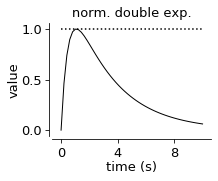

In [21]:
import numpy as np
# double exponential waveform
t = np.linspace(0,10)
_, ax = ge.plot(t, double_exponential(t, .5, 3.), title='double exponential\n normalized waveform',
                axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1],title='norm. double exp.'))
ax.plot(t, np.ones(len(t)), 'k:')

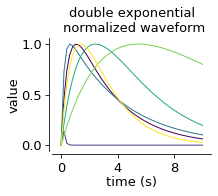

In [22]:
# showing the normalization
_, ax = ge.plot(t,
                Y=[double_exponential(t, .5, 3.),
                   double_exponential(t, .001, .1),
                   double_exponential(t, .2, 4.),
                   double_exponential(t, 3, 2),
                   double_exponential(t, 5, 6.),
                   double_exponential(t, 1, 2)],
                title='double exponential\n normalized waveform',
                axes_args=dict(xlabel='time (s)', ylabel='value', yticks=[0,0.5,1]));

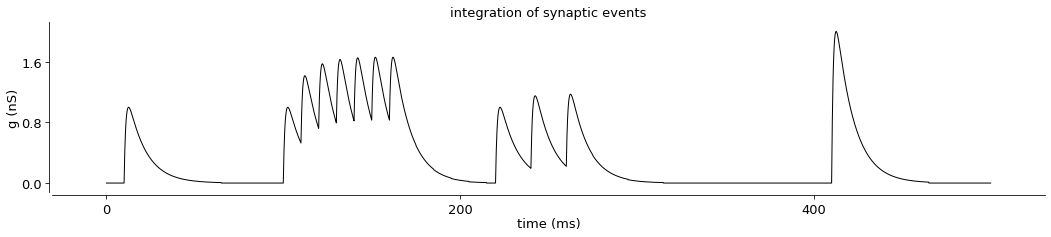

In [23]:
# conductance traces with time parameters
dt, tstop = 0.1, 500 # in ms
t = np.arange(int(tstop/dt))*dt

# generated by a set of events:
SET_OF_EVENTS = [10, 100, 110, 120, 130, 140, 150, 160, 220, 240, 260, 410, 410] # ms, N.B. double events !
conductance = compute_time_variations_from_events(SET_OF_EVENTS, t,
                                              Trise=1, Tdecay=10, # also in ms
                                              quantal=1.) # 1nS peak increment at each event 

ge.plot(t, conductance,
        title='integration of synaptic events', fig_args={'figsize':(2.5,1.5)},
        axes_args=dict(xlabel='time (ms)', ylabel='g (nS)'));

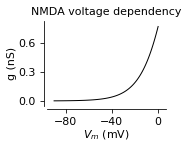

In [8]:
# Voltage dependency of NMDA current

Vm= np.linspace(-90e-3,0e-3,100) 

fig, ax = ge.plot(1e3*Vm, voltage_dep_NMDA(Vm),
                    title='NMDA voltage dependency')
ge.set_plot(ax, xlabel='$V_m$ (mV)', ylabel='g (nS)')

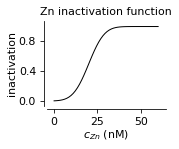

In [9]:
# Inactivation function of Zinc effect

c = np.linspace(0,60e-9)

fig, ax = ge.plot(1e9*c, inactivation_function(c, c0=params['C0_Zn'], dc=params['deltaC_Zn']),
                    title='Zn inactivation function')
ge.set_plot(ax, xlabel='$c_{Zn}$ (nM)', ylabel='inactivation')

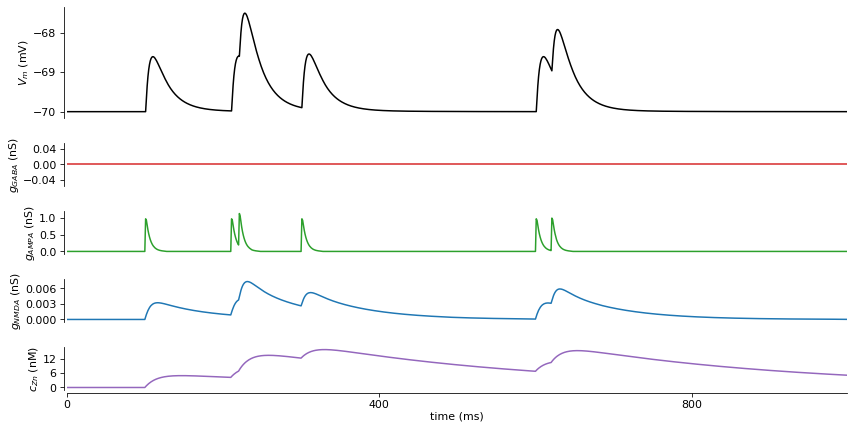

In [10]:
# temporal dynamics of the model current clamp

sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              result_type='current-clamp')
plot_temporal_dynamics(sim, ge);

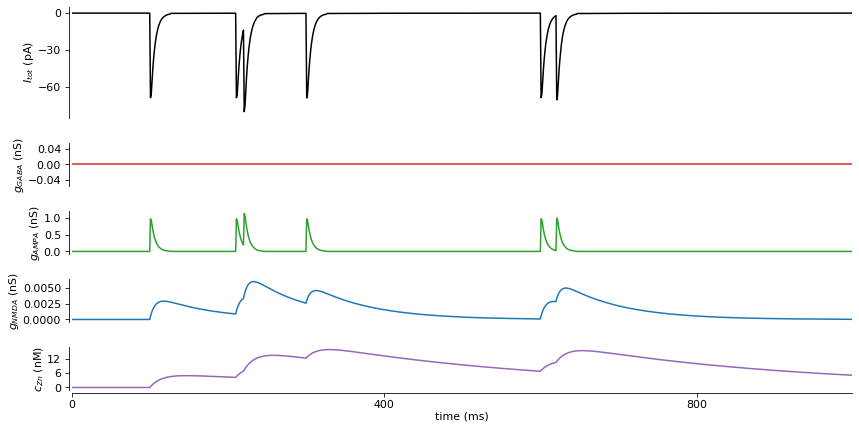

In [11]:
# same events in voltage-clamp -> hyperpolarized
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = -70e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

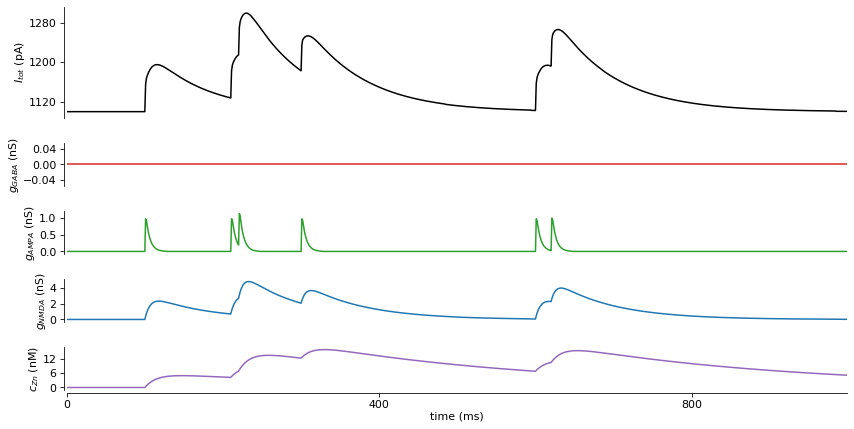

In [12]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim = solve_membrane_equation(np.arange(1000)*1e-3, params,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim, ge);

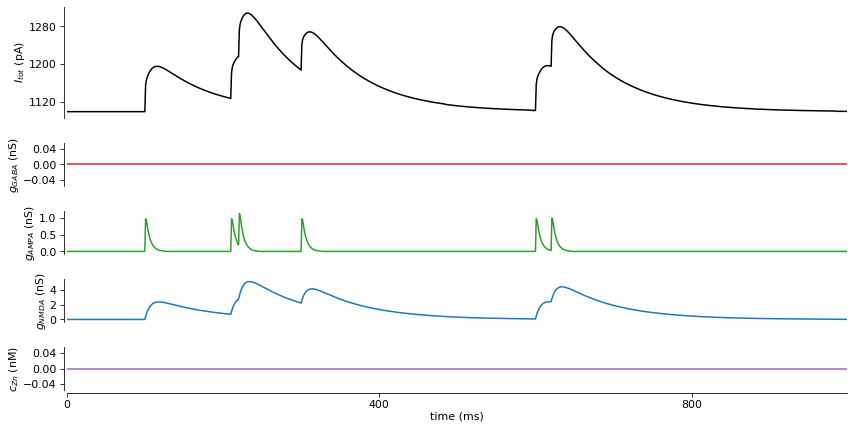

In [13]:
# same events in voltage-clamp -> highly depolarized (+40 mV)
sim_no_Zn = solve_membrane_equation(np.arange(1000)*1e-3, params_no_Zn,
                              Glut_events=[0.1, 0.21, 0.22, 0.3, 0.6, 0.62],
                              Vm = + 40e-3,
                              result_type='voltage-clamp')
plot_temporal_dynamics(sim_no_Zn, ge); # note the increase of the last events

## Response to pulse trains

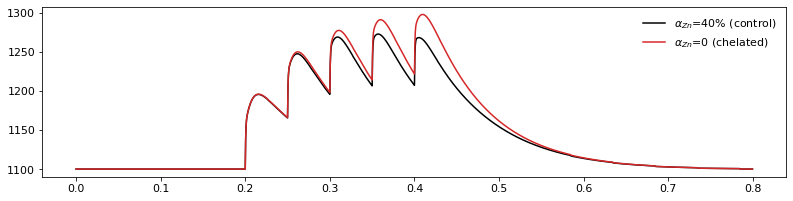

In [14]:
# protocol setup
tstop, dt = 800e-3, 5e-4
t = np.arange(int(tstop/dt))*dt
SET_OF_EVENTS = [200e-3, 250e-3, 300e-3, 350e-3, 400e-3] # 5 pulses at 20Hz freq
# with Zinc modulation
sim = solve_membrane_equation(t, params, Glut_events=SET_OF_EVENTS,
                              Vm = + 40e-3,
                              result_type='voltage-clamp')

# without Zinc modulation
sim_no_Zn = solve_membrane_equation(t, params_no_Zn, Glut_events=SET_OF_EVENTS,
                              Vm = + 40e-3,
                              result_type='voltage-clamp')

_, ax = ge.figure(figsize=(2.5,2))
ax.plot(t, 1e12*sim['Itot'], color='k', label=r'$\alpha_{Zn}$=40% (control)')
ax.plot(t, 1e12*sim_no_Zn['Itot'], color=ge.red, label=r'$\alpha_{Zn}$=0 (chelated)')
ax.legend(frameon=False)

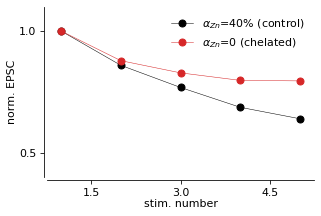

In [15]:
# from the above simulations, normalized EPSCs analysis
_, ax = ge.figure(figsize=(1.5,2))
STIM_NUMBER = range(1, len(SET_OF_EVENTS)+1)
# we look for the peak current in between two stimulation events
for simulation, c, condition in zip([sim, sim_no_Zn],
                                    ['k', ge.red],                                   
                                [r'$\alpha_{Zn}$=40% (control)', r'$\alpha_{Zn}$=0 (chelated)']):
    nEPSCS = []
    for t1, t2 in zip(SET_OF_EVENTS, SET_OF_EVENTS[1:]+[t[-1]]):
        I0 = simulation['Itot'][int(t1/dt)] # current reight before new event as baseline
        IMAX = simulation['Itot'][int(t1/dt):int(t2/dt)].max() # max in between two events
        nEPSCS.append(IMAX-I0) # EPSCs are the difference
        
    ax.plot(STIM_NUMBER, np.array(nEPSCS)/nEPSCS[0], 'o-', color=c, label=condition, lw=.5, ms=7)
ax.legend(frameon=False)
ge.set_plot(ax, xlabel='stim. number', ylabel='norm. EPSC', ylim=[0.4,1.1], yticks=[0.5,1])  